## Teacher-Student Learning with JAX

In [3]:
import jax.numpy as jnp  # Numpy but in jax!
from jax import grad, jit, vmap  # Differentiation, compilation, vectorization
import numpy as np
import matplotlib.pyplot as plt
from utils import load_plot_config  # Nice plot config (Thanks to Sarah)
from jax.scipy.special import erf  # Activation function
from tqdm import tqdm  # loading bar
load_plot_config()  
np.random.seed(0)

## Important JAX concepts
- jit: Decorator that compiles a function for faster execution. Functions need to be static (all variables are known at compile time)
- grad: Computes the gradient of a function
- vmap: Vectorizes a function along a specific axis

We will focus on the two layer neural network from Goldt et al. 2019 which extend Saad and Solla 1995
which uses a non-linear function as activation of the first layer 
$$g(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{\frac{x}{\sqrt{2}}}e^{-t^{2}}dt = \text{erf}\left(\frac{x}{\sqrt{2}}\right)$$

In [4]:
@jit
def error_function(x):
    return erf(x/jnp.sqrt(2.0))

Now we take advantage of JAX's automatic differentiation capabilities to compute the derivative of the error function which is needed for the dynamical equations

In [5]:
error_function_derivative = grad(error_function)
vmap_error_function_derivative = vmap(error_function_derivative, in_axes=0)

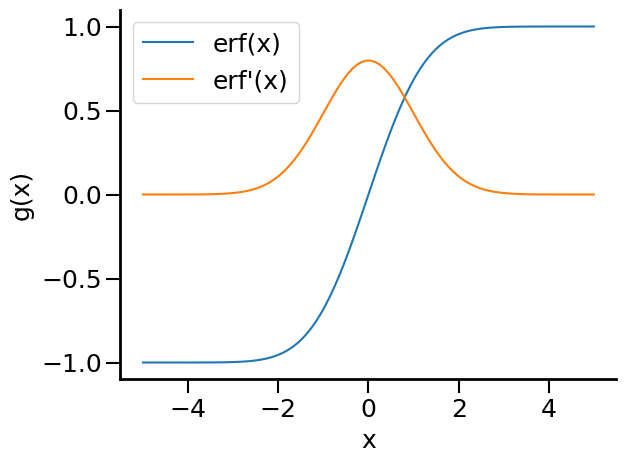

In [6]:
x = jnp.linspace(-5, 5, 100)
plt.plot(x, error_function(x), label='erf(x)')
plt.plot(x, vmap_error_function_derivative(x), label='erf\'(x)')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.legend()
plt.show()

We define a two layer neural network as the teacher with the following architecture
$$ y=   f(x) = V^{*} g\left(\frac{W^{*} x}{\sqrt{N}}\right) $$
with $V^{*}\in \mathbb{R}^{1 \times M}$ and $W^{*}\in \mathbb{R}^{M\times N}$, $N$ being the input dimension and $M$ the number of hidden units, and the error function previously defined as activation function $g(x) = \text{erf}(x/\sqrt{2})$. The student network has the same architecture but with different weights $V$ and $W$, with hidden neurons $K$.

In [7]:
@jit
def erf_net_predict(W2, W1, x, input_dim):
    """ 
    Output of a two layer neural network with error function activation
    W2 (output_dim, hidden_dim): Weights of the second layer
    W1 (hidden_dim, input_dim): Weights of the first layer
    x (input_dim,): Input vector
    input_dim: Dimension of the input vector
    """
    linear_hidden = (W1 @ x)/jnp.sqrt(input_dim)
    hidden_layer = error_function(linear_hidden)
    output = jnp.dot(W2, hidden_layer)
    return output

@jit
def batch_erf_net_predict(W2, W1, x, input_dim):
    """
    Output for a BATCH for a two layer neural network with error function activation
    Now x is a matrix of shape (batch_size, input_dim)
    We "vmap" in the first axis of x to parallelize the computation
    """
    return vmap(erf_net_predict,
                in_axes=(None, None, 0, None))(W2, W1, x, input_dim)

The loss function is the mean squared error between the teacher and student predictions
$$ L = \frac{1}{2N} \sum_{s=1}^{B} \left(y_{s} - y^{*}_{s}\right)^{2} $$
and inputs $x$ are drawn from a normal distribution with zero mean and unit variance. The generalization error $\mathcal{E}$ is computed as an expectation
$$ \mathcal{E} =  \left<L\right>_{x} $$ which in practice is computed with the order parameters, or with a large test set.

In [8]:
@jit
def mse_loss(preds, target):
    return jnp.mean(jnp.square(preds - target))/2.0

@jit
def erf_net_loss(W2, W1, x, y, input_dim):
    preds = batch_erf_net_predict(W2, W1, x, input_dim)
    return mse_loss(preds, y)

### Gradient descent updates, fortunately we don't need to write them explicitely, we can simply use JAX's grad function
# BUT REMEMBER THE SCALING!

$$ W_{i}^{u+1} = W_{i}^{u} + v_{i} \eta_{w} \Delta^{u}  \cdot  g'\left( \frac{W_{i}x^{u}}{\sqrt{N}} \right)  \cdot \frac{x^{u}}{\sqrt{N}}. $$

$$ v_{i}^{u+1} = v_{i}^{u} + \frac{\eta_{w}}{N}\Delta^{u}g(\frac{W_{i}x^{u}}{\sqrt{N}}) $$

In [9]:
@jit
def erf_net_update(W2, W1, x, y, lr, input_dim):
    loss = erf_net_loss(W2, W1, x, y, input_dim)
    # The gradient is computed with respect to the first two arguments of the los function
    # So grad will return a tuple with the gradients of the loss with respect to W2 and W1
    grads = grad(erf_net_loss, argnums=(0, 1))(W2, W1, x, y, input_dim)
    # You can also use jax.value_and_grad to get the loss and the gradient at the same time
    # Avoiding an extra evaluation of the loss function
    W2_update = - lr * grads[0]/input_dim  # scaling for the second layer
    W1_update = - lr * grads[1]
    W2_next = W2 + W2_update
    W1_next = W1 + W1_update
    return W2_next, W1_next, W2_update, W1_update, loss

### Putting everything together in a network class that keeps track of the network weights

In [10]:
class ErfTwoLayerNet(object):

    def __init__(self, W, V, learning_rate=1e-3, weight_scale=1e-5):
        self.W1 = W
        self.W2 = V
        self.lr = learning_rate
        self.init_weight_scale = weight_scale
        self.input_dim = W.shape[1]
        
    def predict(self, x):
        return erf_net_predict(self.W2, self.W1, x, self.input_dim)

    def batch_predict(self, x):
        return batch_erf_net_predict(self.W2, self.W1, x, self.input_dim)

    def loss(self, x, y):
        return erf_net_loss(self.W2, self.W1, x, y, self.input_dim)

    def update(self, x, y):
        self.W2, self.W1, self.last_W2_update, self.last_W1_update, loss = erf_net_update(self.W2, self.W1, x, y, self.lr, self.input_dim)
        return loss

## Defining teacher and student parameters

In [11]:
input_dim = 784  # N in the equations
teacher_hidden_dim = 2  # M
student_hidden_dim = 4  # K
output_dim = 1
teacher_weight_scale = 1.0
student_weight_scale = 0.1
batch_size = 4
learning_rate = 0.1  # eta
test_set_size = 2024
evaluate_every = 3000
training_steps = 150000

W_teacher = np.random.normal(0, teacher_weight_scale, (teacher_hidden_dim, input_dim))
V_teacher = np.random.normal(0, teacher_weight_scale, (output_dim, teacher_hidden_dim))

init_W_student = np.random.normal(0, student_weight_scale, (student_hidden_dim, input_dim))
init_V_student = np.random.normal(0, student_weight_scale, (output_dim, student_hidden_dim))

In [12]:
teacher_net = ErfTwoLayerNet(W_teacher, V_teacher)
student_net = ErfTwoLayerNet(init_W_student, init_V_student, learning_rate=learning_rate)

In [13]:
test_loss = []
save_steps = []
# Use a large test batch as a proxi of generalization error
gen_x = np.random.normal(0, 1, (test_set_size, input_dim))
gen_y = teacher_net.batch_predict(gen_x)
for step in tqdm(range(training_steps)):
    if step % evaluate_every == 0:
        loss = student_net.loss(gen_x, gen_y)
        test_loss.append(loss)
        save_steps.append(step)
    x = np.random.normal(0, 1, (batch_size, input_dim))
    y = teacher_net.batch_predict(x)
    student_net.update(x, y)

100%|██████████| 150000/150000 [01:27<00:00, 1718.85it/s]


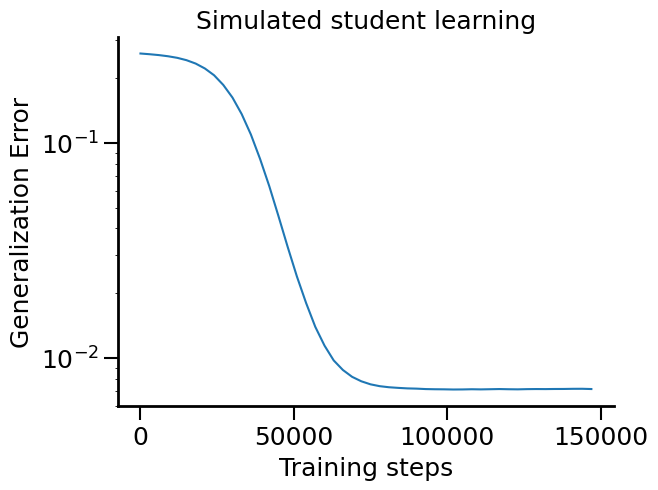

In [14]:
plt.plot(save_steps, test_loss)
plt.xlabel('Training steps')
plt.ylabel('Generalization Error')
plt.title("Simulated student learning")
plt.yscale('log')
plt.show()

## Writing order parameter equations for student dynamics

$$ \begin{equation}
R = \frac{W(W^{*})^{T}}{N}, \hspace
{0.2cm} 
Q = \frac{W W^{T}}{N} \hspace{0.2cm} \text{and} \hspace{0.2cm} T = \frac{W^{*}(W^{*})^{T}}{N}.
\end{equation} $$

In [15]:
@jit
def order_parameters(W1_student, W1_teacher, N):
    Q = jnp.dot(W1_student, W1_student.T)/N
    R = jnp.dot(W1_student, W1_teacher.T)/N
    T = jnp.dot(W1_teacher, W1_teacher.T)/N
    return Q, R, T

### Integral expressions

![image info](images/integrals.png)

In [16]:
@jit
def get_I2(c12, c11, c22):
    e_c11 = jnp.expand_dims(jnp.diag(c11), axis=-1)
    e_c22 = jnp.expand_dims(jnp.diag(c22), axis=0)
    denom = jnp.sqrt((1 + e_c11) * (1 + e_c22))
    return jnp.arcsin(c12 / denom) * (2 / jnp.pi)


@jit
def get_I3(c11, c12, c13, c23, c33):
    e_c23 = jnp.expand_dims(c23, axis=0)
    e_c11 = jnp.expand_dims(jnp.diag(c11), axis=(-2, -1))
    e_c12 = jnp.expand_dims(c12, axis=-1)
    e_c13 = jnp.expand_dims(c13, axis=1)
    e_c33 = jnp.expand_dims(jnp.diag(c33), axis=(0, 1))
    lambda3 = get_lambda3(e_c11, e_c13, e_c33)
    num = e_c23 * (1 + e_c11) - e_c12 * e_c13
    denom = jnp.sqrt(lambda3) * (1 + e_c11)
    return 2 / jnp.pi * (num / denom)


@jit
def get_I4(c11, c12, c13, c14, c22, c23, c24, c33, c34, c44):
    e_c11 = jnp.expand_dims(jnp.diag(c11), axis=(1, 2, 3))
    e_c22 = jnp.expand_dims(jnp.diag(c22), axis=(0, 2, 3))
    e_c33 = jnp.expand_dims(jnp.diag(c33), axis=(0, 1, 3))
    e_c44 = jnp.expand_dims(jnp.diag(c44), axis=(0, 1, 2))
    e_c12 = jnp.expand_dims(c12, axis=(2, 3))
    e_c13 = jnp.expand_dims(c13, axis=(1, 3))
    e_c14 = jnp.expand_dims(c14, axis=(1, 2))
    e_c23 = jnp.expand_dims(c23, axis=(0, 3))
    e_c24 = jnp.expand_dims(c24, axis=(0, 2))
    e_c34 = jnp.expand_dims(c34, axis=(0, 1))

    lambda4 = get_lambda4(e_c11, e_c12, e_c22)
    lambda0 = get_lambda0(e_c11, e_c22, e_c12, e_c13, e_c14, e_c23, e_c24, e_c34, lambda4)
    lambda1 = get_lambda1(e_c11, e_c22, e_c12, e_c13, e_c23, e_c33, lambda4)
    lambda2 = get_lambda2(e_c11, e_c22, e_c12, e_c14, e_c24, e_c44, lambda4)

    first_term = 4 / (jnp.sqrt(lambda4) * jnp.pi ** 2)
    second_term = jnp.arcsin(lambda0 / jnp.sqrt(lambda1 * lambda2))
    return first_term * second_term


@jit
def get_lambda0(c11, c22, c12, c13, c14, c23, c24, c34, lambda4):
    return lambda4 * c34 - c23 * c24 * (1 + c11) - c13 * c14 * (1 + c22) + c12 * c13 * c24 + c12 * c14 * c23


@jit
def get_lambda1(c11, c22, c12, c13, c23, c33, lambda4):
    return lambda4 * (1 + c33) - c23 ** 2 * (1 + c11) - c13 ** 2 * (1 + c22) + 2 * c12 * c13 * c23


@jit
def get_lambda2(c11, c22, c12, c14, c24, c44, lambda4):
    return lambda4 * (1 + c44) - c24 ** 2 * (1 + c11) - c14 ** 2 * (1 + c22) + 2 * c12 * c14 * c24


@jit
def get_lambda3(c11, c13, c33):
    return (1 + c11) * (1 + c33) - c13 ** 2


@jit
def get_lambda4(c11, c12, c22):
    return (1 + c11) * (1 + c22) - c12 ** 2

### Generalization loss as a function of order 
$$ \begin{align}
\mathcal{E} = & \frac{1}{2} \sum_{i=1}^{K} v_{i}v_{j} \sum_{j=1}^{K} I_{2}(i, j) - \sum_{n=1}^{M} \sum_{i=1}^{K} v_{i}v_{n}^{*} I_{2}(i, n)+ \frac{1}{2} \sum_{m=1}^{M} \sum_{n=1}^{M} v_{n}^{*}v_{m}^{*} I_{2}(n, m)
\end{align}. $$

In [17]:
@jit
def order_parameter_loss(Q, R, T, teacher_W2, student_W2):
    I2_1 = get_I2(Q, Q, Q)
    first_term_matrix = jnp.dot(student_W2.T, student_W2) * I2_1
    first_term = jnp.sum(first_term_matrix)

    I2_2 = get_I2(R, Q, T)
    second_term_matrix = jnp.dot(student_W2.T, teacher_W2) * I2_2
    second_term = -jnp.sum(second_term_matrix)

    I2_3 = get_I2(T, T, T)
    third_term_matrix = jnp.dot(teacher_W2.T, teacher_W2) * I2_3
    third_term = jnp.sum(third_term_matrix)
    return first_term/2 + second_term + third_term/2

### Update equations
 
$$ \begin{align}
\frac{dR_{\text{in}}}{dt} &= \eta_w v_i \left[ \sum_{m=1}^M v_m^* I_{3}(i,n,m) - \sum_{j=1}^K v_j I_{3}(i,n,j) 
\right] \\
\frac{dQ_{ik}}{dt} &= \eta_w v_i \left[ \sum_{m=1}^M v_m^* I_{3}(i,k,m) - \sum_{j=1}^K v_j I_{3}(i,k,j) \right] \\
&+ \eta_w v_k \left[ \sum_{m=1}^M v_m^* I_{3}(i,k,m) - \sum_{j=1}^K v_j I_{3}(i,k,j) \right] \\
&+ \eta_w^2 v_i v_k \left[ \sum_{n=1}^M \sum_{m=1}^M v_m^* v_n^* I_{4}(i,k,n,m) - 2 \sum_{j=1}^K \sum_{n=1}^M v_j v_n^* I_{4}(i,k,j,n) \right] \\
&+ \eta_w^2 v_i v_k \left[ \sum_{j=1}^K \sum_{l=1}^K v_j v_l I_{4}(i,k,j,l) + \sigma^2 J_{2}(i,k) \right] \\
\frac{dv_i}{dt} &= \eta_w \left[ \sum_{n=1}^M v_n^* I_{2}(i,n) - \sum_{j=1}^K v_j I_{2}(i,j) \right] 
\end{align}, $$

In [18]:
@jit
def r_update(Q, R, T, teacher_v, student_v, lr):
    I3_i_n_m = get_I3(c11=Q, c12=R, c13=R, c23=T, c33=T)
    I3_i_n_k = get_I3(c11=Q, c12=R, c13=Q, c23=R.T, c33=Q)
    first_sum = jnp.sum(jnp.expand_dims(teacher_v, axis=0) * I3_i_n_m, axis=-1)
    second_sum = jnp.sum(jnp.expand_dims(student_v, axis=0) * I3_i_n_k, axis=-1)
    update = lr * student_v.T * (first_sum - second_sum)
    return update


@jit
def v_update(Q, R, T, teacher_v, student_v, lr):
    I2_in = get_I2(c12=R, c11=Q, c22=T)
    I2_ij = get_I2(c12=Q, c11=Q, c22=Q)
    first_sum = jnp.sum(teacher_v * I2_in, axis=1)
    second_sum = jnp.sum(student_v * I2_ij, axis=1)
    update = lr * (first_sum - second_sum)
    return jnp.expand_dims(update, axis=0)


@jit
def Q_update(Q, R, T, teacher_v, student_v, lr):
    I3_ikm = get_I3(c11=Q, c12=Q, c13=R, c23=R, c33=T)
    I3_ikj = get_I3(c11=Q, c12=Q, c13=Q, c23=Q, c33=Q)
    I4_ikmn = get_I4(c11=Q, c12=Q, c13=R, c14=R, c22=Q, c23=R, c24=R, c33=T, c34=T, c44=T)
    I4_ikjn = get_I4(c11=Q, c12=Q, c13=Q, c14=R, c22=Q, c23=Q, c24=R, c33=Q, c34=R, c44=T)
    I4_ikjl = get_I4(c11=Q, c12=Q, c13=Q, c14=Q, c22=Q, c23=Q, c24=Q, c33=Q, c34=Q, c44=Q)

    first_sum = jnp.sum(jnp.expand_dims(teacher_v, axis=0)*I3_ikm, axis=-1)
    second_sum = jnp.sum(jnp.expand_dims(student_v, axis=0)*I3_ikj, axis=-1)
    fifth_sum = jnp.sum(
        jnp.expand_dims(teacher_v, axis=(0, 1)) * I4_ikmn * jnp.expand_dims(teacher_v, axis=(0, -1)),
        axis=(2, 3))
    sixth_sum = jnp.sum(
        jnp.expand_dims(teacher_v, axis=(0, 1)) * I4_ikjn * jnp.expand_dims(student_v, axis=(0, -1)),
        axis=(2, 3))
    seventh_sum = jnp.sum(jnp.expand_dims(student_v, axis=(0, 1)) * I4_ikjl * jnp.expand_dims(student_v, axis=(0, -1)),
                                        axis=(2, 3))

    first_term = lr * student_v.T * (first_sum - second_sum)
    second_term = first_term.T
    sum_factor = fifth_sum - 2*sixth_sum + seventh_sum
    third_term = lr**2 * student_v.T * student_v * sum_factor
    update = first_term + second_term + third_term
    # The matrix should be symmetric, but we can enforce it here
    update = jnp.triu(update) + jnp.triu(update, 1).T
    return update

@jit
def order_param_update(Q, R, T, teacher_v, student_v, lr, dt):
    dr = r_update(Q, R, T, teacher_v, student_v, lr)
    dv = v_update(Q, R, T, teacher_v, student_v, lr)
    dq = Q_update(Q, R, T, teacher_v, student_v, lr)
    loss = order_parameter_loss(Q, R, T, teacher_v, student_v)
    return Q + dq*dt, R + dr*dt, student_v + dv*dt, loss

### Putting everything together in a class to compute the equations and keep track of the order parameters

In [19]:
class StudentEq(object):

    def __init__(self, init_W1, init_W2, teacher_W1, teacher_W2, learning_rate):
        
        self.student_W1 = init_W1
        self.N = init_W1.shape[1]
        self.time_constant = 1/self.N  # Time step value that goes to zero in the thermodynamics limit
        self.student_W2 = init_W2
        self.lr = learning_rate
        self.teacher_W1 = teacher_W1
        self.teacher_W2 = teacher_W2
        self.input_dim = init_W1.shape[1]
        self.Q, self.R, self.T = order_parameters(self.student_W1,
                                                  self.teacher_W1,
                                                  self.input_dim)

    def update(self):
        self.Q, self.R, self.student_W2, loss = order_param_update(self.Q,
                                                                   self.R,
                                                                   self.T,
                                                                   self.teacher_W2,
                                                                   self.student_W2,
                                                                   self.lr,
                                                                   self.time_constant)
        return loss

In [20]:
student_eq = StudentEq(init_W_student, init_V_student, W_teacher, V_teacher, learning_rate)

In [21]:
ode_loss = []
for step in tqdm(range(training_steps)):
    loss = student_eq.update()
    ode_loss.append(loss)

100%|██████████| 150000/150000 [00:38<00:00, 3891.76it/s]


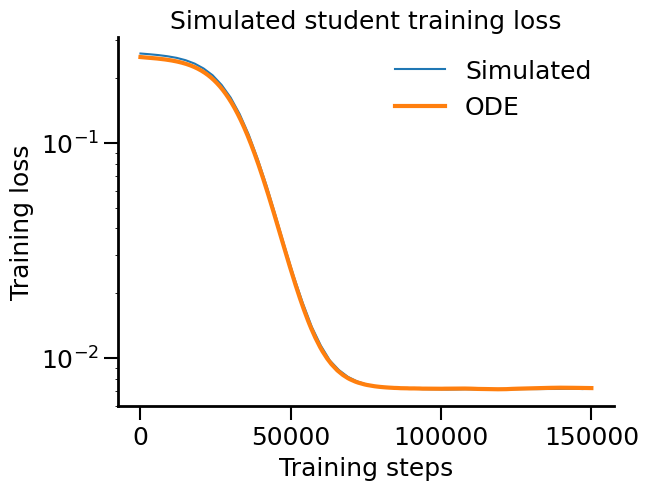

In [22]:
plt.plot(save_steps, test_loss, label='Simulated')
plt.plot(ode_loss, label='ODE', lw=3)
plt.xlabel('Training steps')
plt.ylabel('Training loss')
plt.title("Simulated student training loss")
plt.yscale('log')
plt.legend(frameon=False)
plt.show()